<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Normal Example </font> </h1> </center>
    <center> <h1> <font size="5"> Cholesky Decomposition of Covariance Matrix $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Normal distribution. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

To ensure positive definiteness of $\Sigma(\cdot)$, the $D(D + 1)/2$ entries of the covariance matrix must satisfy specific conditions. For the bivariate case, this can be ensured by applying exponential functions to the variances and a suitable transformation to restrict the coefficient of correlation $\rho \in [-1,1]$. However, in high-dimensional settings, where all moments are modelled as functions of covariates, ensuring positive definiteness of the covariance matrix becomes challenging, since joint restrictions for the elements are necessary. A computationally more tractable approach to ensure positive definiteness is based on the Cholesky decomposition, that uniquely decomposes the covariance matrix as follows

$$
\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)
$$

where $\mathbf{L}(\cdot) \in \mathbb{R}^{D \times D}$ is a lower triangular matrix. To ensure $\mathbf{\Sigma}(\cdot)$ to be positive definite, the $D$ diagonal elements $\ell_{ii}$ of
$\mathbf{L}(\cdot)$ need to be strictly positive, whereas all $D(D −1)/2$ off diagonal elements $\ell_{ij}$ can take on any value. For the trivariate case, the Cholesky factor $\mathbf{L}(\cdot)$ is given as follows

$$
\mathbf{L}(x)= \begin{pmatrix}
\exp\big(\ell_{11}(x)\big) & 0 & 0 \\
\ell_{21}(x) & \exp\big(\ell_{22}(x)\big) & 0 \\
\ell_{31}(x) & \ell_{32}(x) & \exp\big(\ell_{33}(x)\big)\\
\end{pmatrix}
$$

Given the usefulness of the Cholesky decomposition, instead of estimating the entries of $\mathbf{\Sigma}(\cdot)$ directly, Py-BoostLSS estimates the Cholesky factors $\mathbf{L}(\cdot)$ and then uses these for creating $\mathbf{\Sigma}(\cdot)$. However, in contrast to the original formulation of $\mathbf{\Sigma}(\cdot)$, the elements in $\mathbf{L}(\cdot)$ do not have any direct interpretation. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br/>
<br/>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVN import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_simulated_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy distribution and initialize model

In [2]:
distribution = MVN(D=3) # Multivariate Normal, where D specifies the number of target variables
pyboostlss = PyBoostLSS_Regressor(distribution) # initializes model

# Data

In [3]:
data_sim = load_simulated_data("sim_triv_gaussian.csv")

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train["x"].values.reshape(-1,1)
y_train = train.filter(regex="y").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate["x"].values.reshape(-1,1)
y_eval = validate.filter(regex="y").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test["x"].values.reshape(-1,1)
y_test = test.filter(regex="y").values

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyboostlss.hyper_opt(params=hp_dict,
                                 dtrain=dtrain,
                                 eval_sets=eval_sets,
                                 use_hess=True, 
                                 sketch_method="proj",
                                 hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                                 ntrees=500,                 # Number of boosting iterations.
                                 es=20,                      # Early stopping rounds
                                 n_trials=100,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                 max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                                 silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-05 14:43:12,363] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

[14:43:21] Stdout logging level is INFO.
[14:43:21] GDBT train starts. Max iter 500, early stopping rounds 20
[14:43:25] Iter 0; Sample 0, NLL-score = 9159.097514649005; 
[14:43:42] Early stopping at iter 283, best iter 263, best_score 7044.187375765239
[I 2022-12-05 14:43:42,468] Trial 0 finished with value: 7044.1875 and parameters: {'lr': 0.1558435081316784, 'max_depth': 2, 'sketch_outputs': 3, 'lambda_l2': 35.11016881402264, 'colsample': 0.7833804357866407, 'subsample': 0.8842605465240376, 'min_gain_to_split': 53.196536295253836}. Best is trial 0 with value: 7044.1875.
[14:43:42] Stdout logging level is INFO.
[14:43:42] GDBT train starts. Max iter 500, early stopping rounds 20
[14:43:42] Iter 0; Sample 0, NLL-score = 8481.327933285344; 
[14:43:45] Early stopping at iter 49, best iter 29, best_score 7104.789121997672
[I 2022-12-05 14:43:46,051] Trial 1 finished with value: 7104.7890625 and parameters: {'lr': 0.44510304831717556, 'max_depth': 4, 'sketch_outputs': 8, 'lambda_l2': 38.2

# Model Training

In [5]:
opt_params = opt_param.copy()

pyboostlss_model = pyboostlss.train(dtrain=dtrain,
                                    lr=opt_params["lr"], 
                                    lambda_l2=opt_params["lambda_l2"],
                                    max_depth=opt_params["max_depth"],
                                    sketch_outputs=opt_params["sketch_outputs"],
                                    colsample=opt_params["colsample"],
                                    subsample=opt_params["subsample"],
                                    min_gain_to_split=opt_params["min_gain_to_split"],
                                    ntrees=opt_params["opt_rounds"],
                                    use_hess=True,
                                    verbose=100,                                
                                    sketch_method="proj",
                                    seed=123)

[15:17:33] Stdout logging level is INFO.
[15:17:33] GDBT train starts. Max iter 256, early stopping rounds 100
[15:17:33] Iter 0; 
[15:17:39] Iter 100; 
[15:17:45] Iter 200; 
[15:17:49] Iter 255; 


# Predict

In [6]:
# Predicts transformed parameters of the specified distribution. Py-BoostLSS returns the elements of the covariance matrix, instead of the Cholesky factors.
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_test,
                                    pred_type="parameters")

predt_params

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,0.224880,1.155931,0.940598,0.585310,1.589593,1.268212,0.757025,0.282469,0.695850
1,-0.194072,0.447024,1.470896,0.682757,1.827325,1.744468,0.900789,0.644857,0.579060
2,0.531661,0.518843,1.811656,0.957893,1.718993,1.003292,0.689953,0.687135,0.440522
3,0.399314,0.528477,1.675182,0.882701,1.385204,1.026017,0.909249,0.655127,0.448229
4,0.134528,0.611573,1.828276,0.799054,1.716959,1.378680,0.773228,0.730342,0.550171
...,...,...,...,...,...,...,...,...,...
1995,0.051806,0.083176,1.025441,0.636767,1.086076,1.128140,0.916961,0.536312,0.718651
1996,-0.194072,0.447024,1.470896,0.682757,1.827325,1.744468,0.900789,0.644857,0.579060
1997,0.531661,0.518843,1.811656,0.957893,1.718993,1.003292,0.689953,0.687135,0.440522
1998,0.101487,1.320964,0.987788,0.634893,1.491601,1.295210,0.712173,0.307955,0.718777


In [7]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,
                                     pred_type="samples",   
                                     n_samples=1000)

predt_samples.shape # Shape is (n_samples, n_obs, n_target)

(1000, 2000, 3)

# Plot

In the following, we compare the true moments of the multivariate Gaussian with the ones predicted by Py-BoostLSS. The below figure shows that the estimated parameters of the multivariate Gaussian closely match the true parameters.

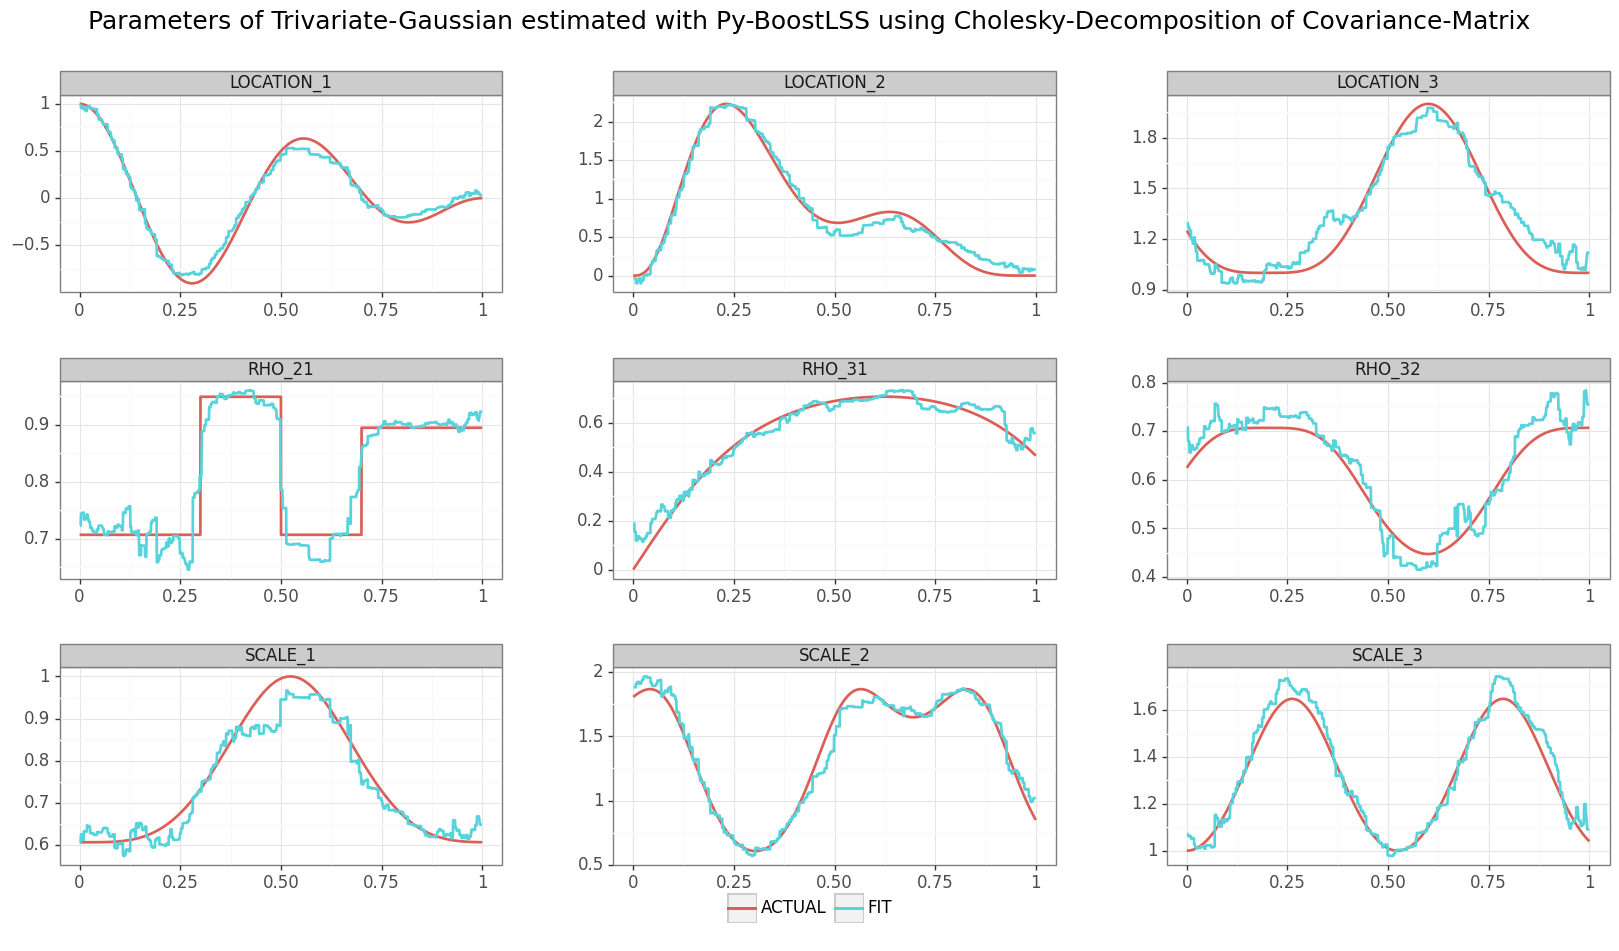

In [8]:
predt_params["x"] = x_test
dist_params = list(predt_params.columns)
drop_cols = [resp for resp in list(data_sim.columns) if "y" in resp]

# Data with actual values
plot_df_actual = pd.melt(data_sim.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)
plot_df_actual["type"] = "ACTUAL"

# Data with predicted values
plot_df_predt = pd.melt(predt_params,
                        id_vars="x",
                        value_vars=dist_params)
plot_df_predt["type"] = "FIT"

plot_df = pd.concat([plot_df_actual, plot_df_predt])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free") + 
               labs(title="Parameters of Trivariate-Gaussian estimated with Py-BoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)